<a href="https://colab.research.google.com/github/smahesh2694/MVTec_GradCAM/blob/master/MVTec_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dependencies

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt

import keras.backend as K
from keras.layers import Conv2D
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from google.colab.patches import cv2_imshow
from skimage.transform import resize

In [ ]:
# Load the trained model. We here load the model trained in 'MVTec_ResNet101V2.ipynb'

saved_model = load_model('/content/drive/My Drive/xai_model/MVTec_RN101_40_FT.h5')

# Grad-CAM

Grad-CAM implementation based on https://github.com/totti0223/gradcamplusplus/blob/master/gradcamutils.py

In [ ]:
# Load the gradcamutils.py file 

%cd '/content/drive/My Drive/xai_model'
import gradcamutils

In [6]:
# Find the convolutional layers in our network.

conv_layers = []
for i in range(len(saved_model.layers)):
  if type(saved_model.layers[i]) == Conv2D:
    conv_layers.append(saved_model.layers[i].name)

In [7]:
labels=  {'defective_bottle': 0, 'defective_cable': 1, 'defective_capsule': 2, 'defective_carpet': 3, 'defective_grid': 4, 
          'defective_hazelnut': 5, 'defective_leather': 6, 'defective_metalnut': 7, 'defective_pill': 8, 'defective_screw': 9, 
          'defective_tile': 10, 'defective_toothbrush': 11, 'defective_transistor': 12, 'defective_wood': 13, 'defective_zipper': 14, 
          'good_bottle': 15, 'good_cable': 16, 'good_capsule': 17, 'good_carpet': 18, 'good_grid': 19, 'good_hazelnut': 20, 
          'good_leather': 21, 'good_metalnut': 22, 'good_pill': 23, 'good_screw': 24, 'good_tile': 25, 'good_toothbrush': 26, 
          'good_transistor': 27, 'good_wood': 28, 'good_zipper': 29}

CLASSES = ['defective_bottle','defective_cable','defective_capsule','defective_carpet',
           'defective_grid','defective_hazelnut','defective_leather','defective_metalnut',
           'defective_pill','defective_screw','defective_tile','defective_toothbrush',
           'defective_transistor','defective_wood','defective_zipper','good_bottle',
           'good_cable','good_capsule','good_carpet','good_grid',
           'good_hazelnut','good_leather','good_metalnut','good_pill',
           'good_screw','good_tile','good_toothbrush','good_transistor',
           'good_wood','good_zipper']

Predicted Class : [3] defective_carpet


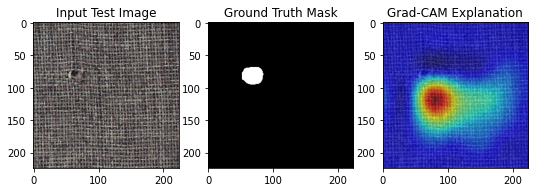

In [16]:
# Load the defective and ground truth images.

image_path = "/content/drive/My Drive/data/test/defective_carpet/carpet_hole_011.png"   # Change inputs correspondingly.
gt_path = "/content/drive/My Drive/data/ground_truth/defective_carpet/hole/011_mask.png"  # Change inputs correspondingly.

test_img_load = image.load_img(image_path, target_size=(224,224,3))
gt_mask = image.load_img(gt_path, target_size=(224,224,3))

test_img = image.img_to_array(test_img_load)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

label_map_inv = {v:k  for k,v in labels.items()}

result = saved_model.predict(test_img)
prediction = result.argmax(axis=1)

output = label_map_inv[int(prediction)]
print("Predicted Class : "+ str(prediction) + " " + str(output))

gradcam = gradcamutils.grad_cam(saved_model, test_img, layer_name = conv_layers[-1])

plt.figure(figsize=(12, 10))
plt.subplot(141)
plt.title("Input Test Image")
plt.imshow(test_img_load)

plt.subplot(142)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask)

plt.subplot(143)
plt.title("Grad-CAM Explanation")
plt.imshow(test_img_load)
plt.imshow(gradcam,alpha=0.6,cmap="jet")

plt.show()